# Training a Object Detector Model in Pytorch

### Example of Dataset

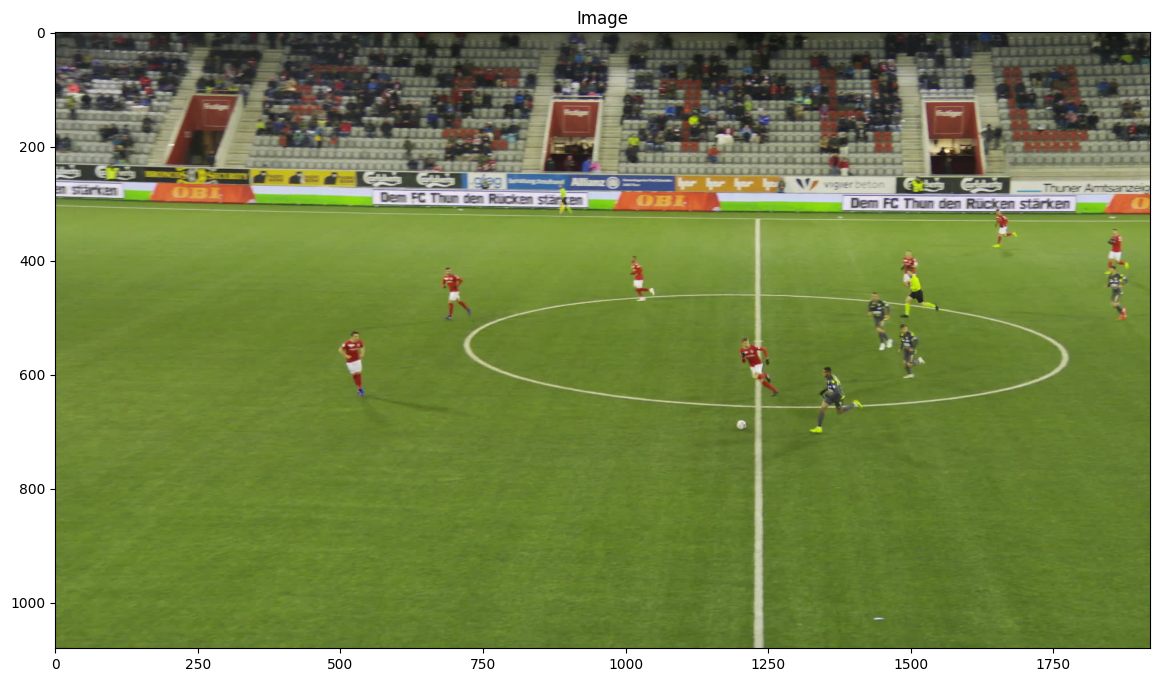

In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
# tracking/YOLO2/dataset
image = read_image("../../tracking/YOLO2/dataset/train/images/000114000435.jpg")

plt.figure(figsize=(16, 8))
# plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))

### Import Libraries

In [2]:
# Import libraries
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision.io import read_image

### Cuda Environment

In [3]:
from torch.nn import DataParallel

os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,4'
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'
print(os.environ['CUDA_VISIBLE_DEVICES'])


torch.cuda.is_available()
torch.cuda.device_count()

2,3,4


3

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Dataloader

In [5]:
# Define Dataset
class SoccerDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        """
        CustomDataset for Object Detector Training in Pytorch
        """
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform

        self.image_files = [f.split('.')[0] for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load Image
        image_path = os.path.join(self.images_dir, self.image_files[idx] + '.jpg') # Get Image Path
        image = Image.open(image_path).convert("RGB") # Load image and conver to RBG

        # Load labels
        label_path = os.path.join(self.labels_dir, self.image_files[idx] + '.txt') # Get Labels path
        boxes = []
        labels = []

        with open(label_path, 'r') as file:
            for line in file:
                # This line is for integers
                # xmin, ymin, xmax, ymax, class_id = map(int, line.strip().split())
                parts = line.strip().split()
                xmin, ymin, xmax, ymax = map(float, parts[:-1])
                class_id = int(parts[-1])
                
                # Add coordinates to boxes list
                boxes.append([xmin, ymin, xmax, ymax])

                if class_id == 7: # Ball
                    class_id = 2 # Clase 2 es balon
                else: # Jugadores, arbitros, porteros, extra
                    class_id = 1 # Clase 1 es jugador
                labels.append(class_id)

        # Convertir a tensores
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Crear un diccionario con la imagen y las anotaciones
        num_objs = len(labels)
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = int(image_id)
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transform:
            image = self.transform(image)

        return image, target

### Get additional resources (python files)

In [6]:
# This lines are commented because we already have the files
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

### Get Model

In [6]:
# import torchvision.models.detection as detection
# from torchvision.models import ResNet50_Weights
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

    # Obtener el número de características de entrada del clasificador
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Reemplazar la cabeza del clasificador con una nueva
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

### Transforms Method: get_transforms(train)

In [8]:
# # Transforms Method Modified
# # The lines commentend are an alternative method with v2 library
# # from torchvision.transforms import v2 as T
# from torchvision import transforms as T

# def get_transform(train):
#     transforms = []
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
#         # transforms.append(T.ToDtype(torch.float, scale=True))
#         # transforms.append(T.ConvertImageDtype(torch.float)) # Cambia el tipo de datos a float
#         transforms.append(T.ToTensor())
#     transforms.append(T.ConvertImageDtype(torch.float32))
#     transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])) # Escala los valores (ImageNet)
#     # transforms.append(T.ToPureTensor())
    
#     return T.Compose(transforms)

In [9]:
# # V2 version
# from torchvision.transforms import v2 as T

# def get_transform(train):
#     transforms = []
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
#     transforms.append(T.ToDtype(torch.float, scale=True))
#     transforms.append(T.ToPureTensor())
#     return T.Compose(transforms)

In [7]:
# Original
from torchvision import transforms as T

def get_transform(train):
    transforms = []
    # if train:
        # transforms.append(T.RandomHorizontalFlip(0.5))

    transforms.append(T.ToTensor())
    # transforms.append(T.ConvertImageDtype(torch.float32))
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])) # Escala los valores

    return T.Compose(transforms)

### Loading Dataset

In [11]:
from torch.utils.data import DataLoader, random_split
import utils

train_dataset = SoccerDataset(images_dir = '../../tracking/YOLO2/dataset/train/images/',
                        labels_dir='../../tracking/faster_rcnn/data/train/labels/', 
                        transform=get_transform(train=True))
print(len(train_dataset))

test_dataset = SoccerDataset(images_dir = '../../tracking/YOLO2/dataset/test/images/',
                        labels_dir='../../tracking/faster_rcnn/data/test/labels/', 
                        transform=get_transform(train=False))
print(len(test_dataset))

42750
36750


In [12]:
# This code is whitout Test Directory
# # Divide los datos en entrenamiento y validación
# n_val = int(len(dataset) * 0.3)  # 20% para validación
# n_train = len(dataset) - n_val
# train_dataset, val_dataset = random_split(dataset, [n_train, n_val])
# print(len(train_dataset))
# print(len(val_dataset))
    
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True, collate_fn=utils.collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True, collate_fn=utils.collate_fn)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, collate_fn=utils.collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True, collate_fn=utils.collate_fn)

### Testing forward() method

In [14]:
# # Load Pre trained Model
# OriginalModel = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
# OriginalModel.to(device)
# OriginalModel = DataParallel(OriginalModel)

In [15]:
# # For Training
# images, targets = next(iter(train_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = OriginalModel(images, targets)  # Returns losses and detections
# print(output)

In [16]:
# # For inference
# OriginalModel.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = OriginalModel(x)  # Returns predictions
# print(predictions[0])

## Train

In [17]:
from engine import train_one_epoch, evaluate

In [18]:
model = get_model(num_classes=3)
model.train()
model.to(device)
model = DataParallel(model)

In [19]:
print(len(train_dataset)/4) # Each batch
print(len(test_dataset)/4)

10687.5
9187.5


In [20]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [21]:
# Num epochs
num_epochs = 2

In [22]:
import sys

# Guarda las referencias originales de stdout y stderr
original_stdout = sys.stdout
original_stderr = sys.stderr

# Abre un archivo de texto para guardar los logs, con buffering de línea
log_file = open("training_log.txt", "a", buffering=1)

# Redirige la salida estándar y la salida de error al archivo de texto
sys.stdout = log_file
sys.stderr = log_file

In [ ]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, test_loader, device=device )
    torch.save(model.state_dict(), "FasterRCNN_pytorch_training_"+str(epoch)+"epoch.pth")
    
print("That's it!")
torch.save(model.state_dict(), "FasterRCNN_pytorch_trainingFinal.pth")
torch.onnx.export(model, x, "faster_rcnn_train1.onnx", opset_version = 11)

In [ ]:
log_file.close()
# Restaura la salida estándar y de error a la consola
sys.stdout = original_stdout
sys.stderr = original_stderr

In [ ]:
torch.save(model.state_dict(), "FasterRCNN_pytorch_trainingFinal.pth")
torch.onnx.export(model, x, "faster_rcnn_trainFinal.onnx", opset_version = 11)

## Visual Results

In [39]:
model = get_model(num_classes=3)
model.train()
model.to(device)
model = DataParallel(model)

# Cargar los pesos entrenados
# ruta_modelo = "FasterRCNN_pytorch_training1.pth"
ruta_modelo = "FasterRCNN_pytorch_trainingFinal.pth"
model.load_state_dict(torch.load(ruta_modelo))

<All keys matched successfully>

In [40]:
# Original -> Modified for visual evaluation
from torchvision import transforms as T

def get_transform_eval(train):
    transforms = []
    # transforms.append(T.ToTensor())
    transforms.append(T.ConvertImageDtype(torch.float32))
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])) # Escala los valores

    return T.Compose(transforms)

In [52]:
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# image = read_image("../../tracking/YOLO2/dataset/train/images/000114000435.jpg")
image = read_image("../../tracking/YOLO2/dataset/test/images/000146000444.jpg")
# image = F.to_pil_image(image)

eval_transform = get_transform_eval(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

# print("****")
# print("********"+str(pred))
# print("****")

In [53]:
!ls

01_bad					Training_SSD.ipynb
02_FasterRCNN_1epoch			Training_SSD_before.ipynb
03_FasterRCNN_5epochs			__pycache__
04_FasterRCNN_2epochs_noRotation	coco_eval.py
FasterRCNN_pytorch_trainingFinal.pth	coco_utils.py
FasterRCNN_pytorch_training_0epoch.pth	engine.py
FasterRCNN_pytorch_training_1epoch.pth	engine_semi.py
SwanseaBold.ttf				training_log.txt
Training_FasterRCNN.ipynb		training_log_notFinished_2epochs.txt
Training_RetinaNet.ipynb		transforms.py
Training_RetinaNet_Before.ipynb		utils.py


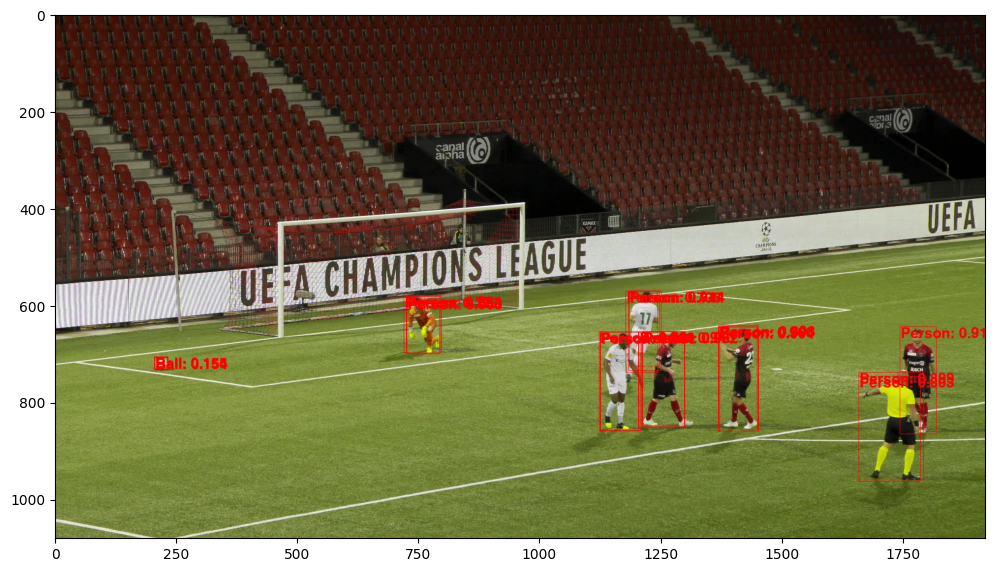

In [54]:
font_path = "SwanseaBold.ttf"

label_names = {1: "Person", 2: "Ball"}

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
threshold = 0.1
filtered_indices = [i for i, score in enumerate(pred["scores"]) if score >= threshold]
# pred_labels = [f"{label}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# pred_labels = [f"{label_names.get(label.item(), 'Unknown')}: {score:.3f}" 
#                for label, score in zip(pred["labels"], pred["scores"])]
# pred_boxes = pred["boxes"].long()
pred_labels = [
    f"{label_names.get(pred['labels'][i].item(), 'Unknown')}: {pred['scores'][i]:.3f}"
    for i in filtered_indices
]
pred_boxes = pred["boxes"][filtered_indices].long()

output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red", font = font_path, font_size = 30)

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [50]:
pred_labels

['Person: 0.980',
 'Person: 0.960',
 'Person: 0.960',
 'Person: 0.952',
 'Person: 0.803',
 'Person: 0.744',
 'Ball: 0.155',
 'Person: 0.971',
 'Person: 0.964',
 'Person: 0.940',
 'Person: 0.910',
 'Person: 0.899',
 'Person: 0.898',
 'Person: 0.735',
 'Ball: 0.154',
 'Person: 0.994',
 'Person: 0.991',
 'Person: 0.932',
 'Person: 0.914',
 'Person: 0.227',
 'Ball: 0.154']

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# COCO_CLASSES = [    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',     'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',     'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',     'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',     'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',     'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',     'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',     'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',     'hair drier', 'toothbrush']

COCO_CLASSES = [    'person', 'ball']

def plot_predictions(img_tensor, prediction):
    

    # Convertir el tensor de la imagen a numpy y desnormalizar
    img_np = img_tensor.squeeze().permute(1, 2, 0).numpy()
    
    # Crear una figura y ejes
    fig, ax = plt.subplots(1, figsize=(12, 9))
    
    # Mostrar la imagen
    ax.imshow(img_np)
    
    # Extraer los bounding boxes y las etiquetas
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores']
    # keep = torchvision.ops.nms(boxes, scores, 0.95)
    # keep = keep.cpu().numpy()
    # print(keep)

    boxes = boxes.cpu().numpy()
    scores = scores#.cpu().numpy()

    # boxesKeep = [boxes[i] for i in keep]
    # labelsKeep = [labels[i] for i in keep]
    # scoresKeep = [scores[i] for i in keep]

    scores = scores.cpu().numpy()
    # Dibujar todos los bounding boxes
    # for box, label, score in zip(boxesKeep, labelsKeep, scoresKeep):
    for box, label, score in zip(boxes, labels, scores):
        class_name = COCO_CLASSES[label - 1]  # -1 porque COCO comienza desde 1
        if score > 0.000001:  # Solo mostramos las detecciones con una confianza superior al 50%
            x, y, xmax, ymax = box
            rect = plt.Rectangle((x, y), xmax-x, ymax-y, fill=False, color='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(x, y, f"Class: {class_name}, Score: {score:.2f}", color='white', backgroundcolor='red', fontsize=8, bbox=dict(facecolor='red', alpha=0.5, edgecolor='red', boxstyle='round,pad=0.1'))


            # ax.text(x, y, f"{class_name}: {score:.2f}", ...)
    plt.axis('off')
    plt.show()

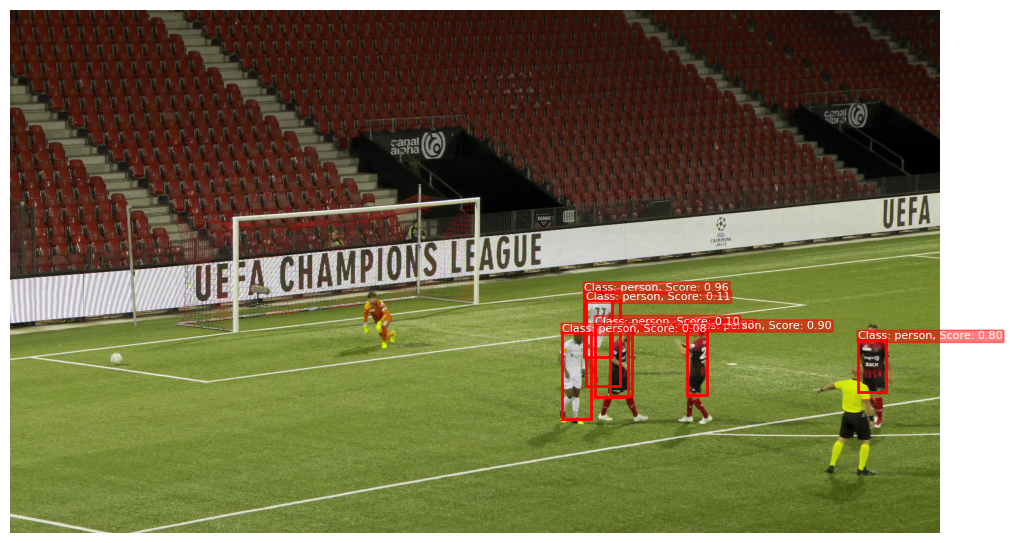

In [33]:
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import torchvision

# # Cargar el modelo preentrenado
# model = fasterrcnn_resnet50_fpn(pretrained=True)

# Poner el modelo en modo de evaluación
model.eval()

# Cargar y preprocesar la imagen
# image_path = "soccer.jpg"
# image_path = "../challenge/SNMOT-021/img1/000675.jpg"
# image_path = "../../tracking/YOLO2/dataset/train/images/000114000435.jpg"
image_path = "../../tracking/YOLO2/dataset/test/images/000146000444.jpg"
# image = Image.open(image_path).convert("RGB")
# image_tensor = F.to_tensor(image).unsqueeze(0)
image = T.ToTensor()(Image.open(image_path)).unsqueeze(0)

# Obtener predicciones
with torch.no_grad():
    prediction = model(image)

# Visualizar las predicciones
plot_predictions(image.squeeze(), prediction)